In [24]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [25]:
class VariationalAutoEncoder:

    network_architecture = []
    transfer_fct = 0

    x = []
    x_reconstr_mean = []
    z = []
    z_mean = []
    z_log_sigma_sq = []

    sess = 0
    cost = 0
    optimizer = 0

    def __init__(self,network_architecture,transfer_fct=tf.nn.sigmoid):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct

        self.x = tf.placeholder(tf.float32,[None,network_architecture["n_input"]])

    def _create_network(self,batch_size):
        network_weights = self._initialize_weights(**self.network_architecture)

        self.z_mean, self.z_log_sigma_sq = self._recognition_network(network_weights["weights_recog"],network_weights["biases_recog"])

        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((batch_size,n_z),0,1,dtype=tf.float32)

        self.z = tf.add(self.z_mean,tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)),eps))

        self.x_reconstr_mean = self._generator_network(network_weights["weights_gener"],network_weights["biases_gener"])

    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        all_weights = dict()

        all_weights['weights_recog'] = { 'h1' : tf.Variable(self.xavier_init(n_input,n_hidden_recog_1)), \
                                         'h2' : tf.Variable(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2)), \
                                         'out_mean': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z)), \
                                         'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z))}


        all_weights['biases_recog'] = { 'b1' : tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.float32)), \
                                        'b2' : tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.float32)), \
                                        'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)), \
                                        'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}

        all_weights['weights_gener'] = {'h1': tf.Variable(self.xavier_init(n_z, n_hidden_gener_1)), \
                                        'h2': tf.Variable(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2)), \
                                        'out_mean': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input)), \
                                        'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input))}

        all_weights['biases_gener'] = {'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)), \
                                       'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)), \
                                       'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)), \
                                       'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

    def _recognition_network(self,weights,biases):
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2,weights['out_mean']),biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])

        return (z_mean,z_log_sigma_sq)

    def _generator_network(self,weights,biases):
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))

        return x_reconstr_mean

    def _create_loss_optimizer(self,learning_rate):
        reconstr_loss = -tf.reduce_sum(self.x*tf.log(1e-10+self.x_reconstr_mean)+(1-self.x)*tf.log(1e-10+1-self.x_reconstr_mean),1)
        latent_loss = -0.5*tf.reduce_sum(1+self.z_log_sigma_sq-tf.square(self.z_mean)-tf.exp(self.z_log_sigma_sq),1)

        self.cost = tf.reduce_mean(reconstr_loss+latent_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

    def partial_fit(self,x):
        opt,cost = self.sess.run((self.optimizer,self.cost),feed_dict={self.x:x})
        return cost

    def transform(self,x):
        return self.sess.run(self.z_mean,feed_dict={self.x:x})

    def generate(self,z_mu=None):
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.z:z_mu})

    def reconstruct(self,x):
        return self.sess.run(self.x_reconstr_mean,feed_dict={self.x:x})

    def xavier_init(self,fan_in, fan_out, constant=1):
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))

        return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

    def train(self,trainX,batch_size=100,training_epochs=500,learning_rate=0.0005):
        self._create_network(batch_size)
        self._create_loss_optimizer(learning_rate)

        init = tf.initialize_all_variables()
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
        self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        self.sess.run(init)

        startTime = time.time()
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(len(trainX)/batch_size)

            for i in range(total_batch):
                batch = []
                for j in range(batch_size):
                    batch.append(trainX[i*batch_size+j])
                cost = self.partial_fit(batch)
                avg_cost += cost / n_samples*batch_size

            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime)))  # - startTime.microsecond) / 1e6))
        return

    def plotReconstruct(self,testData,strFileName):
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])

        x_reconstruct = self.reconstruct(testData)
        plt.figure(figsize=(8, 12))
        for i in range(5):
            plt.subplot(5, 2, 2 * i + 1)
            plt.imshow(testData[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
            plt.title("Test Input")
            plt.colorbar()

            plt.subplot(5, 2, 2 * i + 2)
            plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
            plt.title("Reconstruction")
            plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotScatter2D(self,testDataFeature,testDataClass,strFileName):
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])

        z_mu = self.transform(testDataFeature)
        plt.figure(figsize=(8, 6))
        plt.scatter(z_mu[:,0],z_mu[:,1],c=np.argmax(testDataClass,1))
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotManifold2D(self,intNumX1,intNumX2,maxX1,minX1,maxX2,minX2,batch_size,strFileName):
        x1s = np.linspace(minX1, maxX1, intNumX1)
        x2s = np.linspace(minX2, maxX2, intNumX2)
        canvas = np.empty((28*intNumX2,28*intNumX1))
        for i, yi in enumerate(x1s):
            for j, xi in enumerate(x2s):
                z_mu = np.array([[xi,yi]]*batch_size)
                x_mean = self.generate(z_mu)
                canvas[(intNumX1-i-1)*28:(intNumX1-i)*28,j*28:(j+1)*28] = x_mean[0].reshape(28,28)
        plt.figure(figsize=(8, 6))
        xi, yi = np.meshgrid(x1s,x2s)
        plt.imshow(canvas,origin='upper',cmap='gray')
        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

In [26]:
network_architecture = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=10)

In [27]:
np.random.seed(0)
tf.set_random_seed(0)

mnist = input_data.read_data_sets('MNIST_DATA',one_hot=True)
n_samples = mnist.train.num_examples

iterations = [1,5]
testX = mnist.test.next_batch(100)[0]
trainX = []
for i in range(n_samples):
    tempTuple = mnist.train.next_batch(1)[0]
    trainX.append(tempTuple[0])

Extracting MNIST_DATA\train-images-idx3-ubyte.gz
Extracting MNIST_DATA\train-labels-idx1-ubyte.gz
Extracting MNIST_DATA\t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA\t10k-labels-idx1-ubyte.gz


Epoch :  0001  Cost =  203.366971713
Elapsed Time : 19.02781915664673
Epoch :  0002  Cost =  183.996598400
Elapsed Time : 37.813249349594116
Epoch :  0003  Cost =  166.623998219
Elapsed Time : 56.496851682662964
Epoch :  0004  Cost =  159.322286904
Elapsed Time : 75.2375876903534
Epoch :  0005  Cost =  155.593114430
Elapsed Time : 93.88675308227539
Epoch :  0006  Cost =  149.363362538
Elapsed Time : 112.52815675735474
Epoch :  0007  Cost =  143.722356429
Elapsed Time : 131.2351632118225
Epoch :  0008  Cost =  140.646748838
Elapsed Time : 150.05086159706116
Epoch :  0009  Cost =  138.707683258
Elapsed Time : 169.88198399543762
Epoch :  0010  Cost =  137.311502200
Elapsed Time : 189.48596167564392
Epoch :  0011  Cost =  136.024593437
Elapsed Time : 209.64232897758484
Epoch :  0012  Cost =  135.004259990
Elapsed Time : 230.13504767417908
Epoch :  0013  Cost =  134.119648604
Elapsed Time : 252.3200478553772
Epoch :  0014  Cost =  133.218516388
Elapsed Time : 273.128103017807
Epoch :  0015 

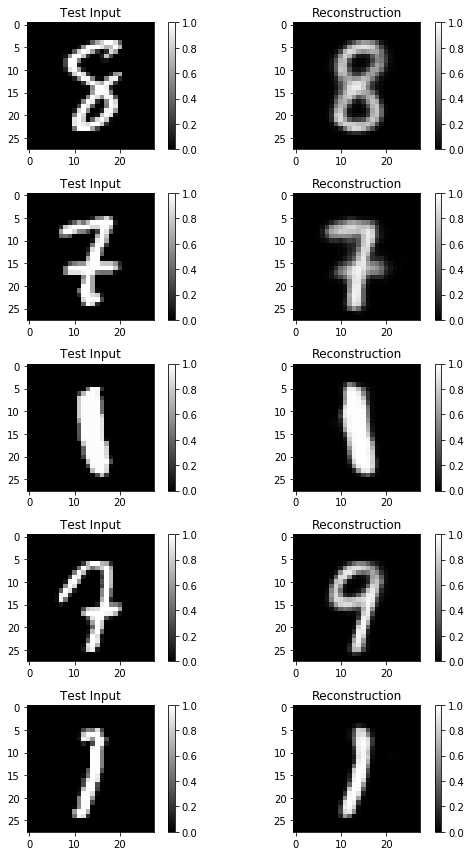

Epoch :  0001  Cost =  235.170366599
Elapsed Time : 16.68270444869995
Epoch :  0002  Cost =  206.396806197
Elapsed Time : 33.35627579689026
Epoch :  0003  Cost =  206.298385620
Elapsed Time : 49.95429754257202
Epoch :  0004  Cost =  206.279803467
Elapsed Time : 66.68090391159058
Epoch :  0005  Cost =  206.260262229
Elapsed Time : 83.33646273612976
Epoch :  0006  Cost =  204.833229204
Elapsed Time : 100.0805811882019
Epoch :  0007  Cost =  194.096712425
Elapsed Time : 116.89774823188782
Epoch :  0008  Cost =  190.493529719
Elapsed Time : 135.42404913902283
Epoch :  0009  Cost =  188.463232422
Elapsed Time : 155.67449688911438
Epoch :  0010  Cost =  187.016526378
Elapsed Time : 179.86608624458313
Epoch :  0011  Cost =  185.734635787
Elapsed Time : 201.2447817325592
Epoch :  0012  Cost =  184.695712558
Elapsed Time : 218.46971940994263
Epoch :  0013  Cost =  183.858309659
Elapsed Time : 235.03271651268005
Epoch :  0014  Cost =  182.837222013
Elapsed Time : 251.6872410774231
Epoch :  0015 

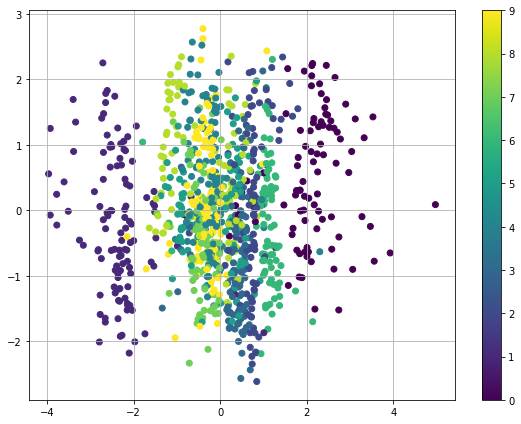

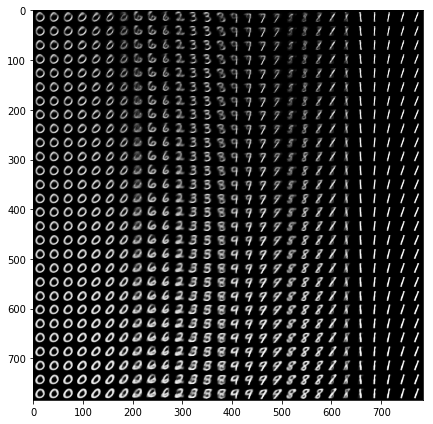

In [28]:
vae = VariationalAutoEncoder(network_architecture)
vae.train(trainX,batch_size=100,training_epochs=100,learning_rate=0.001)
vae.plotReconstruct(testX,'./log/VAE-Reconstruct.png')

network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)

testX,testY = mnist.test.next_batch(1000)

vae2D = VariationalAutoEncoder(network_architecture2D)
vae2D.train(trainX,batch_size=1000,training_epochs=100,learning_rate=0.001)
vae2D.plotScatter2D(testX,testY,'./log/VAE-2D-Scatter.png')
vae2D.plotManifold2D(28,28,-3,3,-3,3,1000,'./log/VAE-2D-Manifold.png')